# Westeros Tutorial
## Adding representation of renewables - Part 3: Introducing `renewable_resource_constraints`

This tutorial, which demonstrates how to apply various model features to provide a more realistic representation of renewable energy integration in the energy system, is comprised of three parts. Previously, we introduced constraints on `firm_capacity` and `flexible_generation`.  In the third part we will show you how to introduce renewable resource potentials.  Up until now, `wind_ppl` activity was unrestricted.  In order to reflect the fact that there are limited wind potentials within a given region and the fact that these differ in quality, we will add introduce `renewable_potnetials` and `renewable_capacity_factors` for wind.

Further information can be found in https://doi.org/10.1016/j.esr.2013.01.001 (*Sullivan et al., 2013*)

In [1]:
import pandas as pd
import ixmp as ix
import message_ix

from message_ix.utils import make_df

%matplotlib inline

In [2]:
mp = ix.Platform(dbtype='HSQLDB')

INFO:root:launching ixmp.Platform with local HSQLDB database at 'C:\Users\fricko\.local\ixmp\localdb\default'


## Load the existing scenario '*carbon_tax*' and clone to a new scenario '*renewable_potential*' to which we will apply the `renewable_resource_constraints` constraint

In [3]:
model = 'Westeros Electrified'
base = message_ix.Scenario(mp, model=model, scenario='carbon_tax')
scen = base.clone(model, 'renewable_potential', 'illustration of renewable_resource_constraint formulation', keep_solution=False)
scen.check_out()

## Retrieve parameters to perform subsequent addition of parameters

In [4]:
year_df = scen.vintage_and_active_years()
vintage_years, act_years = year_df['year_vtg'], year_df['year_act']
model_horizon = scen.set('year')
country = 'Westeros'

## `renewable_resource_constraints` - Describing the renewable resource potentials
From the previous tutorials, we know based on the results that in 720, wind capacity reaches over 150GWa. We will therefore define 4 wind potential categories which in total will provide 200GWa, yet the quality of these potentials will vary substantially from the current assumptions, where the capacity factor for `wind_ppl` has been assumed to be 1, meaning that the installed `wind_ppl` capacity can operate 8760 hours per year i.e., 100% of the year.  Depending on the region, high quality on-shore wind potentials result in capacity factors around 35%, yet the marjority of the potentials will lie below this value.  Therefore, 4 reource categories will be introduced:

| Resource Category | Potential | Capacity Factor |
| ----------------- | --------- | --------------- |
| c1 | 100 | .15 |
| c2 | 50 | .20 |
| c3 | 25 | .25 |
| c4 | 25 | .30 |

The capacity factor of the `wind_ppl` will remain unchanged and will be reflected in the parametrization of the `renewable_resources`.  

The following steps are required:
1. Add level and commodity:
   - Specify and new level and commodity which accounts for the wind potentials and which serve as inputs to the `wind_ppl`
   - Specify which level is a `level_renewable`
2. Modify existing renewable technology:
   - Specify which technology is classified as a `'type_tec` renewable (optional) 
   - Modify the input of the wind_ppl
3. Add potentials and corresponding 
   - Add grades
   - Add `renewable_potentials'
   - Add `renewable_capacity_factor`

### Define new level and commodity which accounts for potentials for wind

In [5]:
scen.add_set('level', ['renewable'])
scen.add_set('commodity', ['wind_onshore'])
scen.add_set('level_renewable', ['renewable'])

### Define a new technology category `renewable`, to which `wind_ppl` is added

In [6]:
scen.add_set('type_tec', ['renewable'])
df = pd.DataFrame({'type_tec': ['renewable'],
                   'technology': ['wind_ppl']})
scen.add_set('cat_tec', df)

### Define input for `wind_ppl` as newly defined level and commodity

In [7]:
# input has index set ['node_loc', 'technology', 'year_vtg', 'year_act',
#                      'mode', 'node_origin', 'commodity', 'level',
#                      'time', 'time_origin', 'value', 'unit]
df = pd.DataFrame({
    'node_loc': country,
    'technology': 'wind_ppl',
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'node_origin': country,
    'commodity': 'wind_onshore',
    'level': 'renewable',
    'time': 'year',
    'time_origin': 'year',
    'value': 1,
    'unit': '%'})
scen.add_par('input', df)

### Add new resource potential categories as `grade`

In [8]:
grades = ['c1', 'c2', 'c3', 'c4']
scen.add_set('grade', grades)

### Add resource potentials for every timestep in the model
Note, that unlike fossil resources which are finite, renewable resources must be defined for each year.

In [9]:
# renewable_potential has index ['node', 'commodity', 'grade', 'level', 'year', 'value', 'unit']
idx = pd.MultiIndex.from_product([[country], ['wind_onshore'], grades, ['renewable'], model_horizon, ['GWa']],
                                 names=['node', 'commodity', 'grade', 'level', 'year', 'unit'])
df = pd.DataFrame({'value': sorted([100, 50, 25, 25] * len(model_horizon), reverse=True)}, idx).reset_index()
scen.add_par('renewable_potential', df)

### Add `renewable_capacity_factor` for every timestep in the model

In [10]:
# renewable_potential has index ['node', 'commodity', 'grade', 'level', 'year', 'value', 'unit']
idx = pd.MultiIndex.from_product([[country], ['wind_onshore'], grades, ['renewable'], model_horizon, ['%']],
                                 names=['node', 'commodity', 'grade', 'level', 'year', 'unit'])
df = pd.DataFrame({'value': sorted([.15, .20, .25, .30] * len(model_horizon))}, idx).reset_index()
scen.add_par('renewable_capacity_factor', df)

### Commit and solve

In [11]:
scen.commit(comment='define parameters for renewable implementation')
scen.set_as_default()

In [12]:
scen.solve()

In [13]:
scen.var('OBJ')['lvl']

290808.5625

# Plotting Results

In [14]:
from tools import Plots
p = Plots(scen, country, firstyear=700) # scenario: 'renewable_potential' (emission_bound scenario with firm capacity)
b = Plots(base, country, firstyear=700) # scenario: 'carbon_tax' (without renewable potentials)

## Activity
***
When comparing the results of the original scenario without the renewable potentials ('*carbon_tax*') with the results of our newly modified scenario ('*renewable_potential*'), for the same carbon price we can observe that the activity of the `wind_ppl` has substantially decreased.  This is because through adding potentials with corresponding plant factors, the `wind_ppl` has become increasingly economicaly unattractive and despite the carbon tax is not used. 
Note, that the `coal_ppl` still has a plant factor of 1 and has no resource constraints, thus in order to further improve the model, the parameters for the `coal_ppl` would need to be adjusted.

### Scenario: '*carbon_tax*'

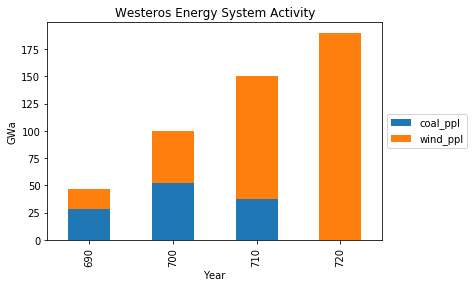

In [15]:
b.plot_activity(baseyear=True, subset=['coal_ppl', 'wind_ppl'])

### Scenario: '*renewable_potential*'

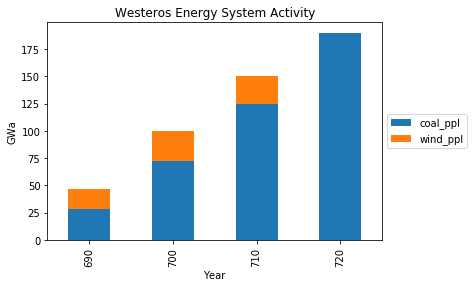

In [16]:
p.plot_activity(baseyear=True, subset=['coal_ppl', 'wind_ppl'])

## Capacity
***
The behavior observed for the activity of the two electricity generation technologies is reflected in the capacity. No further capacity is built for the `wind_ppl` and thus is phased out by 720.

### Scenario: '*carbon_tax*'

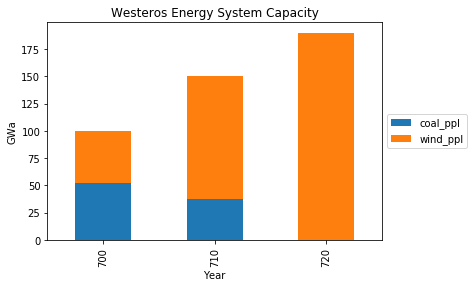

In [17]:
b.plot_capacity(baseyear=True, subset=['coal_ppl', 'wind_ppl'])

### Scenario: '*renewable_potential*'

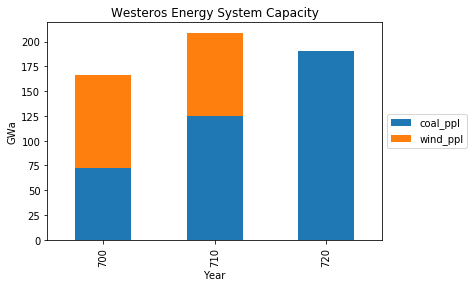

In [18]:
p.plot_capacity(baseyear=True, subset=['coal_ppl', 'wind_ppl'])

## Prices
***
Especially in the earlier model time periods, electricity and therefore the price for light increase dramatically.  The increase in 720 is due to the emission taxes associated with the operation of the `coal_ppl`.

### Scenario: '*carbon_tax*'

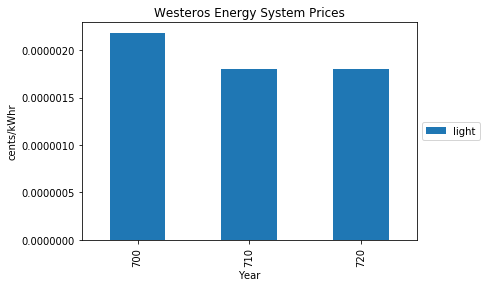

In [19]:
b.plot_prices(subset=['light'], baseyear=True)

### Scenario: '*renewable_potential*'

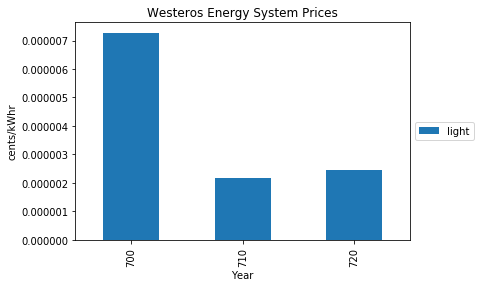

In [20]:
p.plot_prices(subset=['light'], baseyear=True)

In [21]:
mp.close_db()